In [1]:
from typing import Callable, List, Tuple 

import os
import torch
import catalyst

import pandas as pd

from catalyst import utils
from catalyst.utils import imread

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from PIL import Image
from torchvision import transforms

from facenet_pytorch import MTCNN, InceptionResnetV1

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

%matplotlib inline

/home/spknnk/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


torch: 1.4.0, catalyst: 20.01.3


In [2]:
from pathlib import Path

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT = "../train"
ALL_IMAGES = list(Path(ROOT).glob("*.jpg"))
print("Number of images:", len(ALL_IMAGES))

Number of images: 156


In [3]:
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

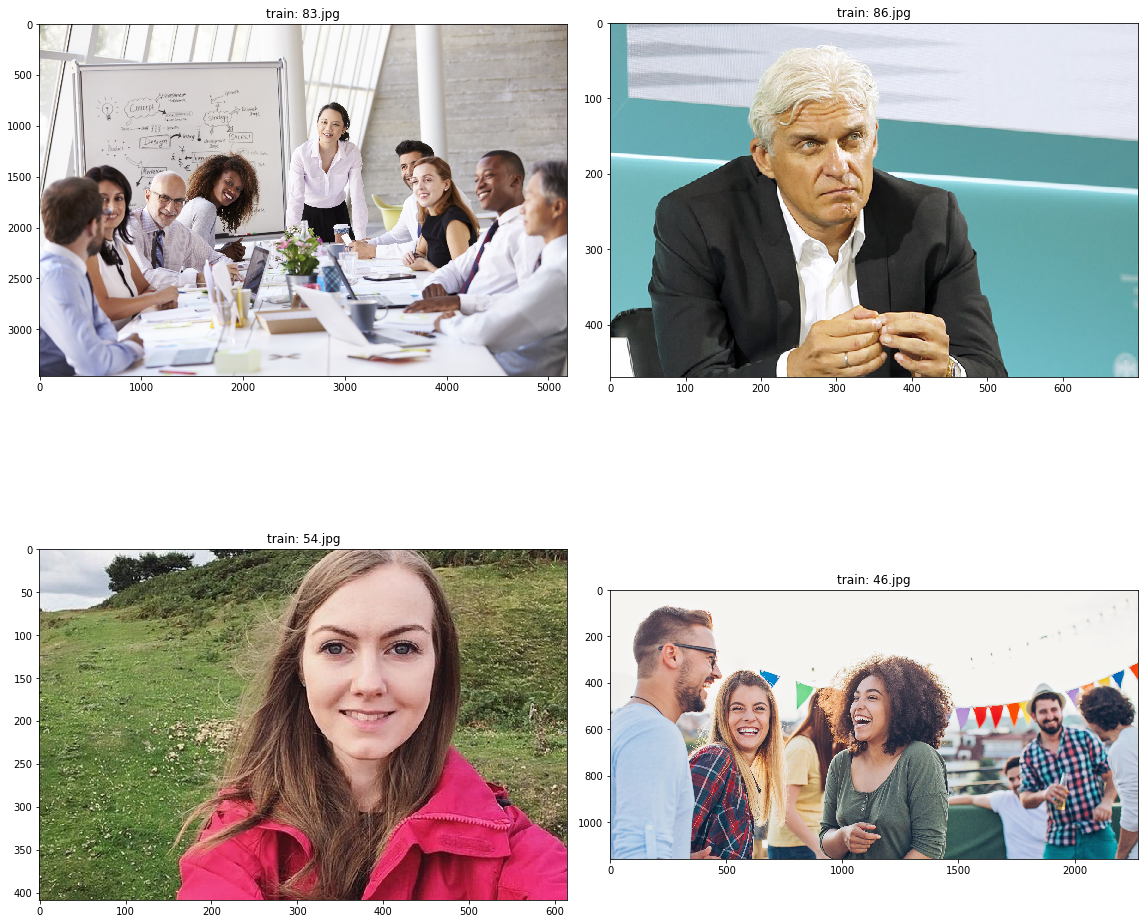

In [4]:
images = read_random_images(ALL_IMAGES)
show_examples(images)

# Pytorch MTCNN

https://github.com/timesler/facenet-pytorch

In [5]:
from facenet_pytorch import MTCNN as MTCNNTorch
from PIL import Image

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


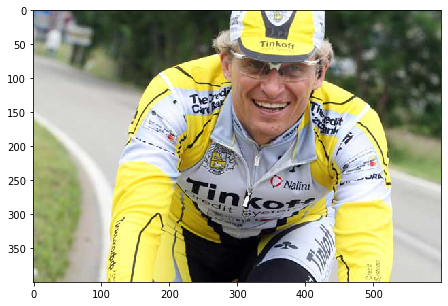

In [6]:
mtcnn = MTCNNTorch(
    image_size=240, margin=0, min_face_size=20,
    post_process=True,
    device=device
)

image_path = "../train/2.jpg"
img = Image.open(image_path)

plt.figure(figsize=(15,5))
plt.imshow(img)
plt.show()

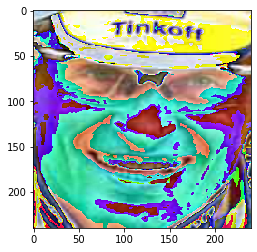

In [7]:
img_cropped = mtcnn(img)
plt.imshow(transforms.ToPILImage()(img_cropped))
plt.show()

Seems to be unclear!

# TF MTCNN

https://github.com/ipazc/mtcnn

In [8]:
from mtcnn import MTCNN
import cv2
import albumentations as albu
detector = MTCNN()

Using TensorFlow backend.


In [9]:
def visualize(image, original_image=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 10

    f, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(original_image)
    ax[0].set_title('Original image', fontsize=fontsize)

    ax[1].imshow(image)
    ax[1].set_title('Transformed image', fontsize=fontsize)
        
def plot_with_augmentation(image, augment):
    """
    Wrapper for `visualize` function.
    """
    sh = 15
    result = detector.detect_faces(image)
    bb = result[0]['box']
    image_cropped = image[max(0, bb[1]-sh):bb[1]+bb[3]+sh, 
                          max(0, bb[0]-sh):bb[0]+bb[2]+sh, :]
    
    augmented = augment(image=image_cropped)
    image_cropped = augmented['image']
    
    visualize(image_cropped, original_image=image)

def get_img(x):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{ROOT}/"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_training_augmentation():
    train_transform = [
        albu.Resize(160, 160),
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(rotate_limit=20, p=0.7),
        albu.OpticalDistortion(p=0.5, distort_limit=0.1, shift_limit=0.2),
    ]
    return albu.Compose(train_transform)

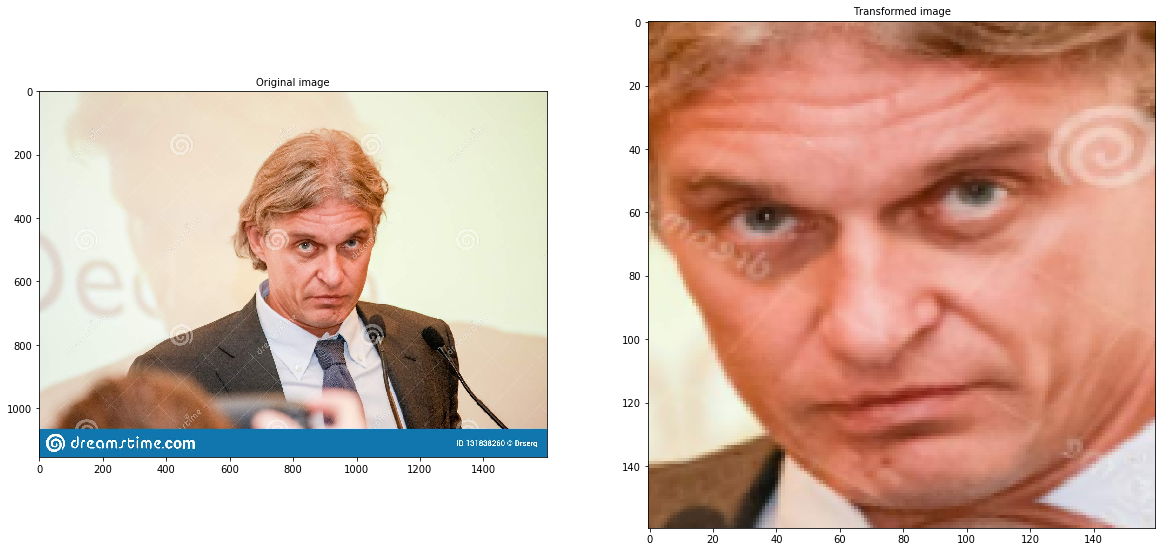

In [10]:
# same for picture by name
image_name = "12.jpg"
image = get_img(image_name)
plot_with_augmentation(image, get_training_augmentation())

A way better then torch version!

Also this MTCNN provides not-only-one face detection. It will be useful for inference!

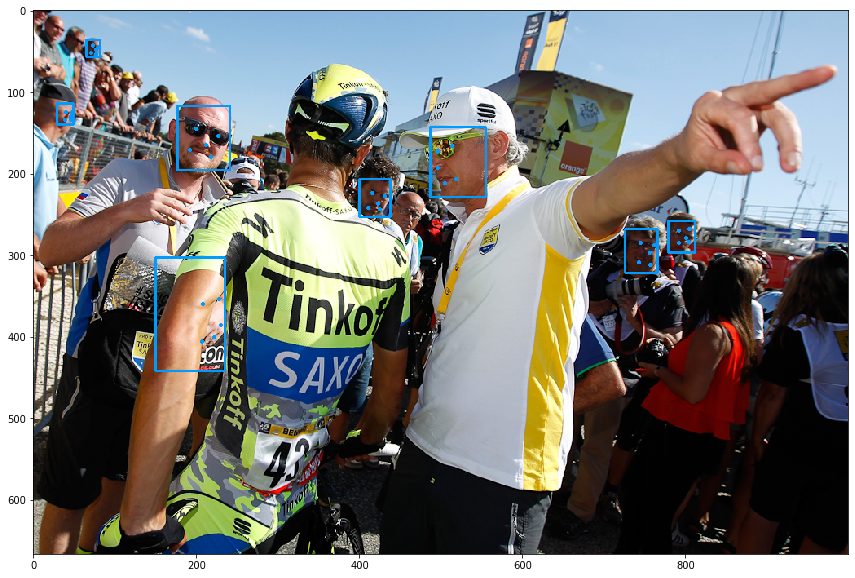

In [11]:
image_name = "14.jpg"
image = get_img(image_name)

result = detector.detect_faces(image)

for i in range(len(result)):
    bounding_box = result[i]['box']
    keypoints = result[i]['keypoints']

    cv2.rectangle(image,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)

    cv2.circle(image,(keypoints['left_eye']), 1, (0,155,255), 2)
    cv2.circle(image,(keypoints['right_eye']), 1, (0,155,255), 2)
    cv2.circle(image,(keypoints['nose']), 1, (0,155,255), 2)
    cv2.circle(image,(keypoints['mouth_left']), 1, (0,155,255), 2)
    cv2.circle(image,(keypoints['mouth_right']), 1, (0,155,255), 2)
    
plt.figure(figsize=(30,10))
plt.imshow(image)
plt.show()